In [7]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from collections import defaultdict
from sklearn.linear_model import Ridge
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from df import df

<Axes: title={'center': 'Weekly Invoice vs Revenue'}, xlabel='week', ylabel='revenue'>

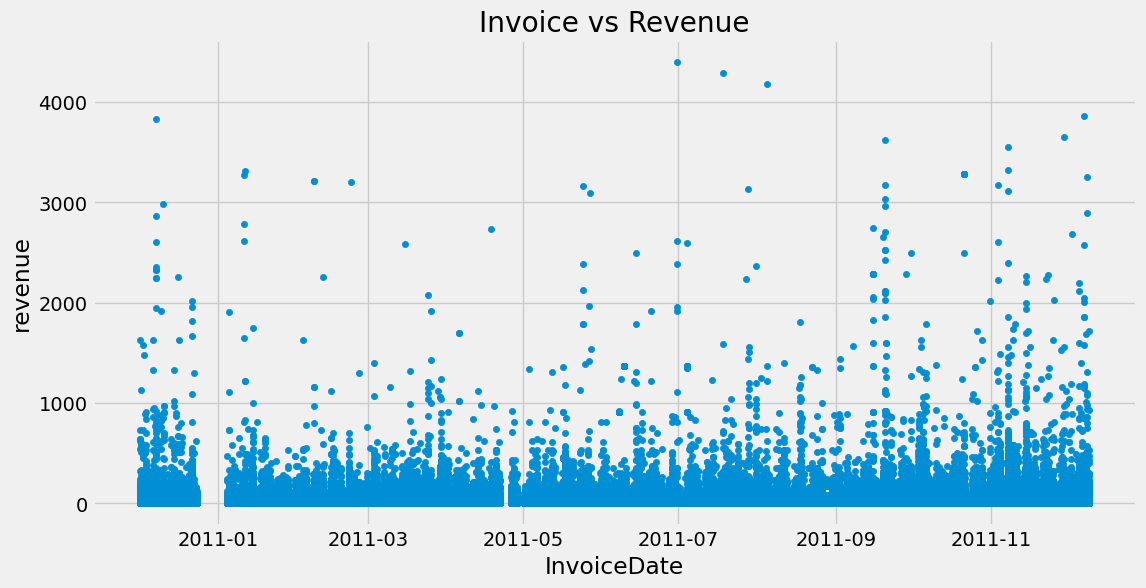

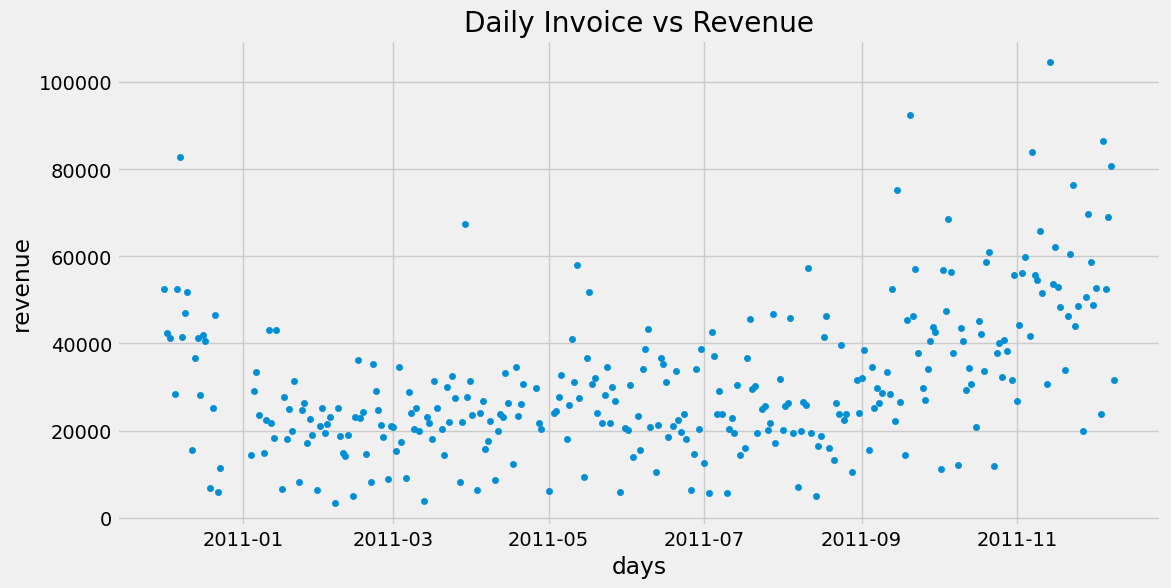

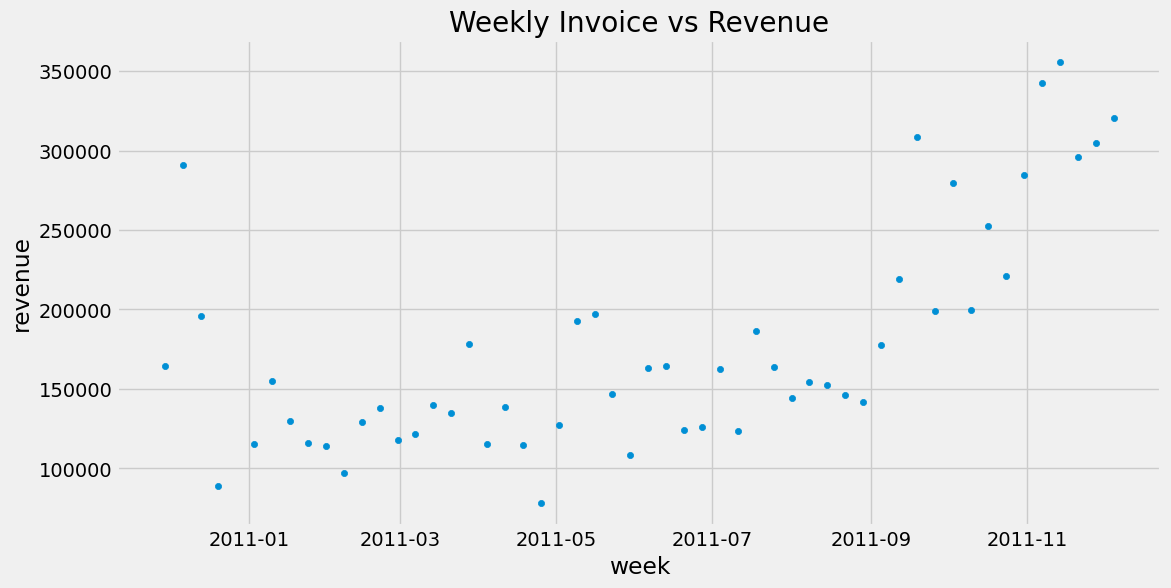

In [8]:
#New Dataframes

df.plot.scatter(x='InvoiceDate', y='revenue',title='Invoice vs Revenue', figsize=(12, 6))

df['days'] = df['InvoiceDate'].dt.date
daily_revenue_df = df.groupby('days')['revenue'].sum().reset_index()
daily_revenue_df.plot.scatter( x='days', y='revenue',title='Daily Invoice vs Revenue', figsize=(12, 6))

df['week'] = df['InvoiceDate'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_revenue_df = df.groupby('week')['revenue'].sum().reset_index()
weekly_revenue_df.plot.scatter(x='week', y='revenue', title='Weekly Invoice vs Revenue', figsize=(12, 6))

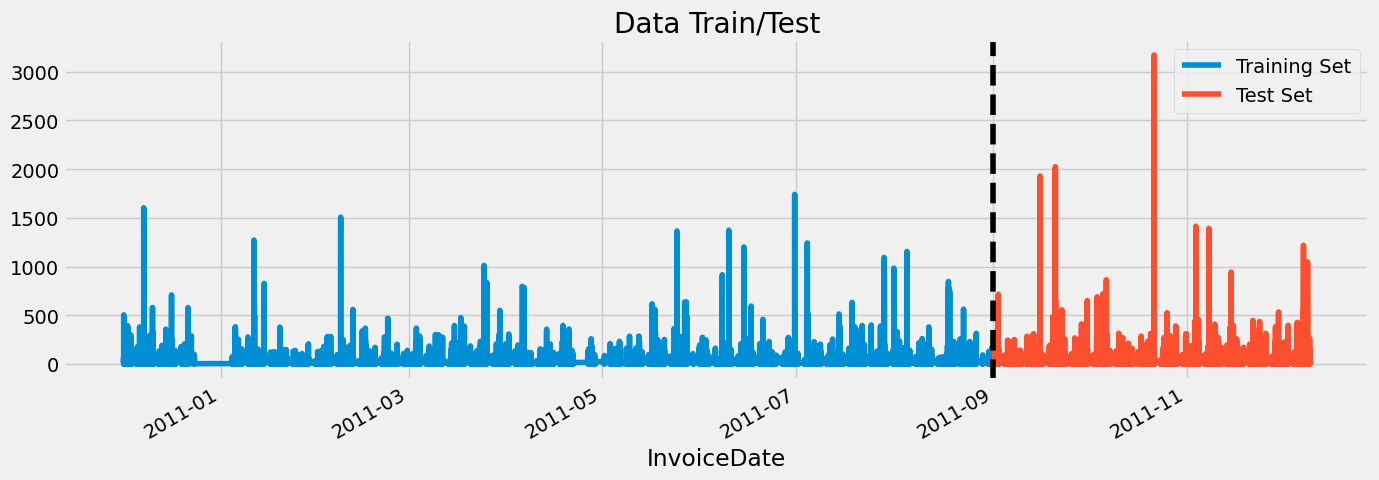

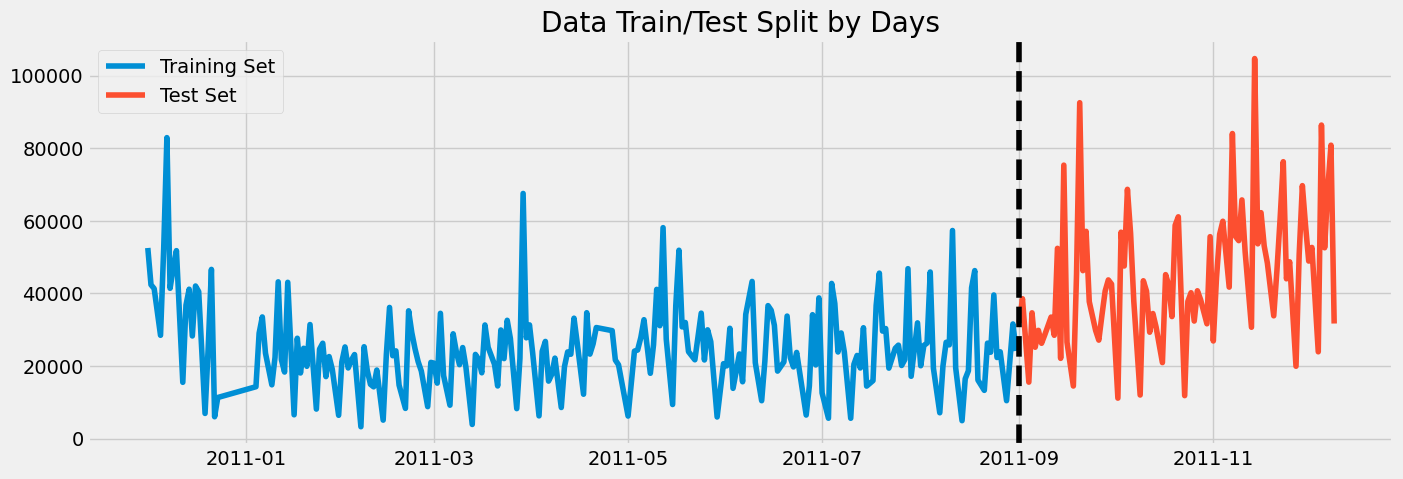

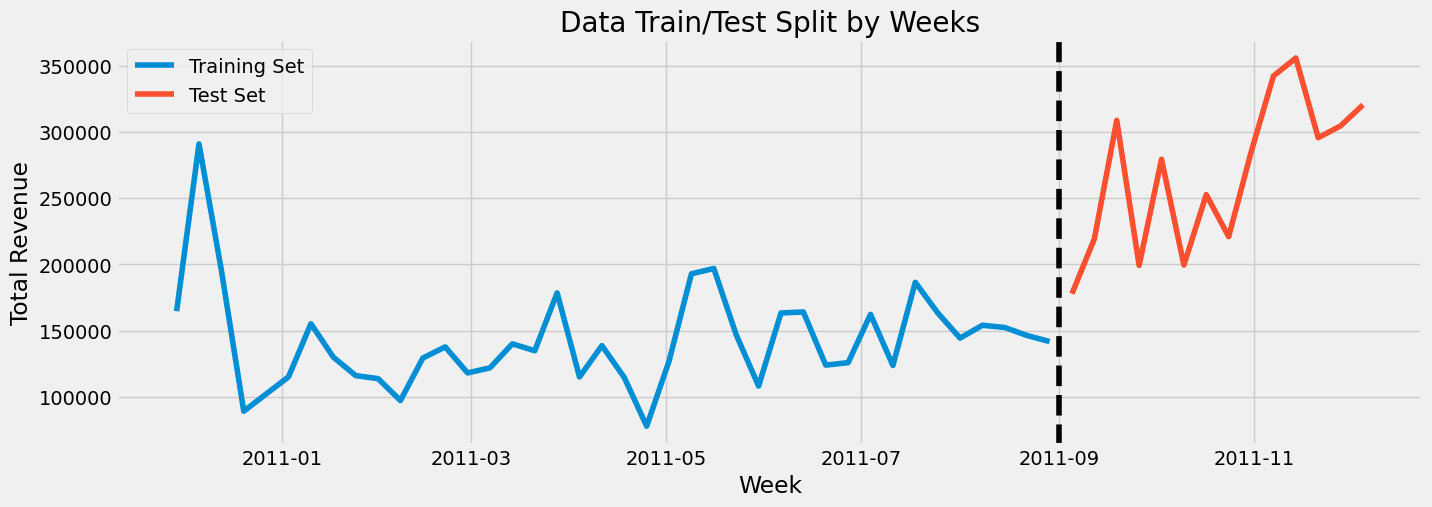

In [9]:
#Split Data

train = df.loc[df.index < '09-01-2011']
test = df.loc[df.index >= '09-01-2011']

fig, ax = plt.subplots(figsize=(15, 5))
train['revenue'].rolling(window=7).mean().plot(ax=ax, label='Training Set')
test['revenue'].rolling(window=7).mean().plot(ax=ax, label='Test Set')
ax.set_title('Data Train/Test')
ax.axvline('09-01-2011', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

#Total Revenue by Day

train1 = daily_revenue_df.loc[pd.to_datetime(daily_revenue_df['days']) < '09-01-2011']
test1 = daily_revenue_df.loc[pd.to_datetime(daily_revenue_df['days']) >= '09-01-2011']

fig, ax = plt.subplots(figsize=(15, 5))

daily_revenue_df['days'] = pd.to_datetime(daily_revenue_df['days'])

ax.plot(train1['days'], train1['revenue'], label='Training Set')
ax.plot(test1['days'], test1['revenue'], label='Test Set')

ax.axvline(pd.to_datetime('09-01-2011'), color='black', ls='--')

ax.set_title('Data Train/Test Split by Days')
ax.legend()
plt.show()



split_date = pd.to_datetime('2011-09-01')

train2 = weekly_revenue_df[weekly_revenue_df['week'] < split_date]
test2 = weekly_revenue_df[weekly_revenue_df['week'] >= split_date]

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(train2['week'], train2['revenue'], label='Training Set')
ax.plot(test2['week'], test2['revenue'], label='Test Set')

ax.axvline(split_date, color='black', linestyle='--')

ax.set_title('Data Train/Test Split by Weeks')
ax.set_xlabel('Week')
ax.set_ylabel('Total Revenue')
ax.legend()
plt.grid(True)
plt.show()

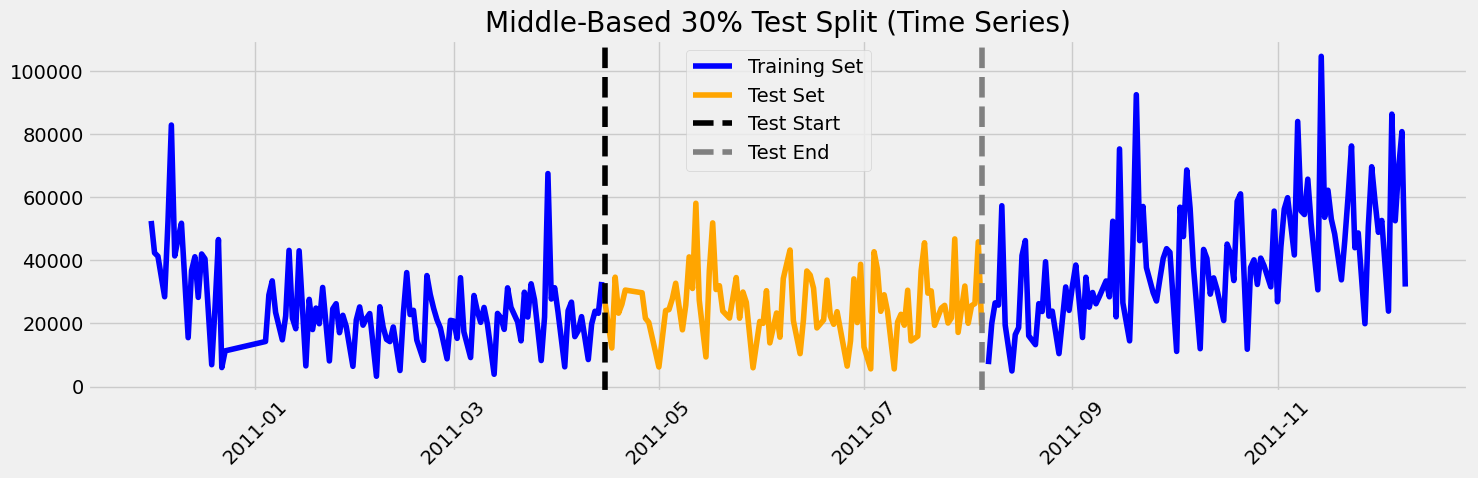

In [ ]:
# Because the months have certain trends within them as a result of holidays, it makes more sense ot test on those aspects, therefore
# we decided to test on the middle 30 % of the data while training on the rest, allowing the model to actually grasp the true 
# nature of the data.

daily_revenue_df['days'] = pd.to_datetime(daily_revenue_df['days'])
daily_revenue_df = daily_revenue_df.sort_values('days').reset_index(drop=True)

# Get indices for the split
total_len = len(daily_revenue_df)
test_size = int(total_len * 0.30)
buffer = int((total_len - test_size) / 2)

# Split the data
train1 = daily_revenue_df.iloc[:buffer]
test1 = daily_revenue_df.iloc[buffer:buffer + test_size]
train2 = daily_revenue_df.iloc[buffer + test_size:]

# Combine training sets
train = pd.concat([train1, train2])

fig, ax = plt.subplots(figsize=(15, 5))

# Plot first and second training blocks separately
ax.plot(train1['days'], train1['revenue'], label='Training Set', color='blue')
ax.plot(train2['days'], train2['revenue'], color='blue')  # No label to avoid duplicate

# Plot test set
ax.plot(test1['days'], test1['revenue'], label='Test Set', color='orange')

# Mark test boundaries
ax.axvline(test1['days'].min(), color='black', ls='--', label='Test Start')
ax.axvline(test1['days'].max(), color='gray', ls='--', label='Test End')

# Titles & legend
ax.set_title('Middle-Based 30% Test Split (Time Series)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



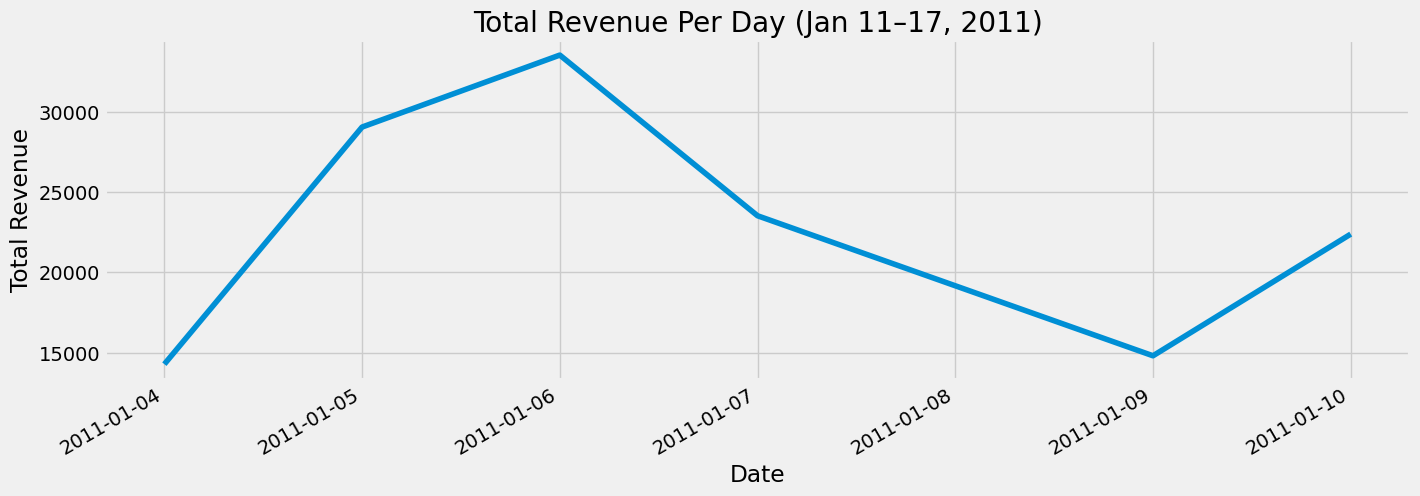

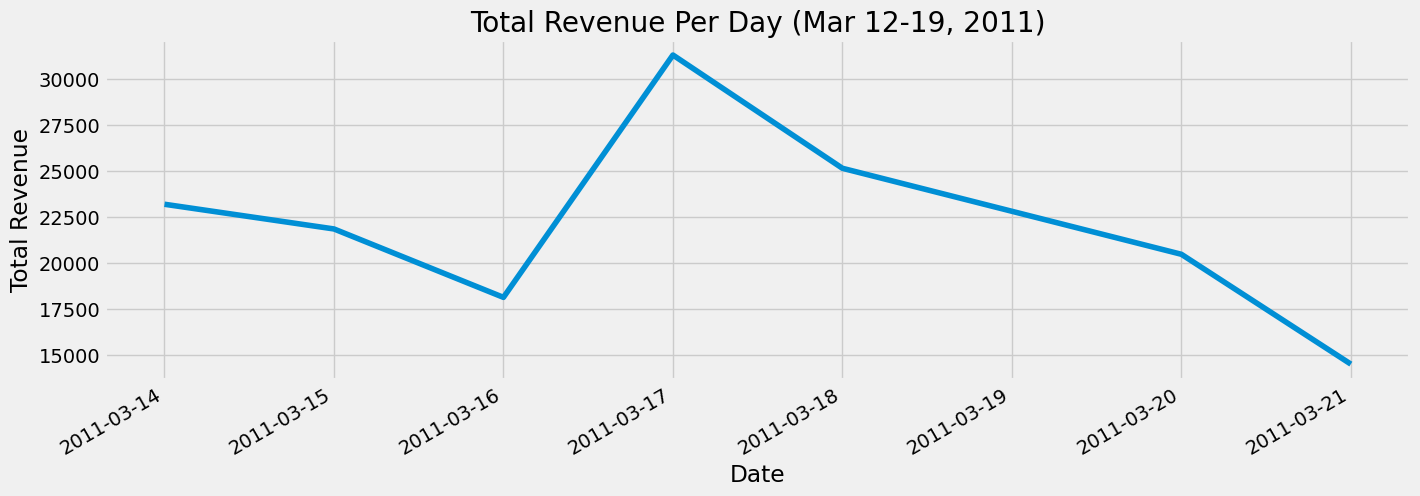

In [11]:
#Total revenue in a week
daily_revenue_df['days'] = pd.to_datetime(daily_revenue_df['days'])

week_df = daily_revenue_df[
    (daily_revenue_df['days'] >= '2011-01-3') & 
    (daily_revenue_df['days'] <= '2011-01-10')
]

week2_df = daily_revenue_df[
    (daily_revenue_df['days'] >= '2011-03-14') & 
    (daily_revenue_df['days'] <= '2011-03-21')
]

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_totals = week_df.groupby('days')['revenue'].sum()
daily_totals2 = week2_df.groupby('days')['revenue'].sum()

daily_totals.plot(figsize=(15, 5), title='Total Revenue Per Day (Jan 11–17, 2011)')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.show()

daily_totals2.plot(figsize=(15, 5), title='Total Revenue Per Day (Mar 12-19, 2011)')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.show()

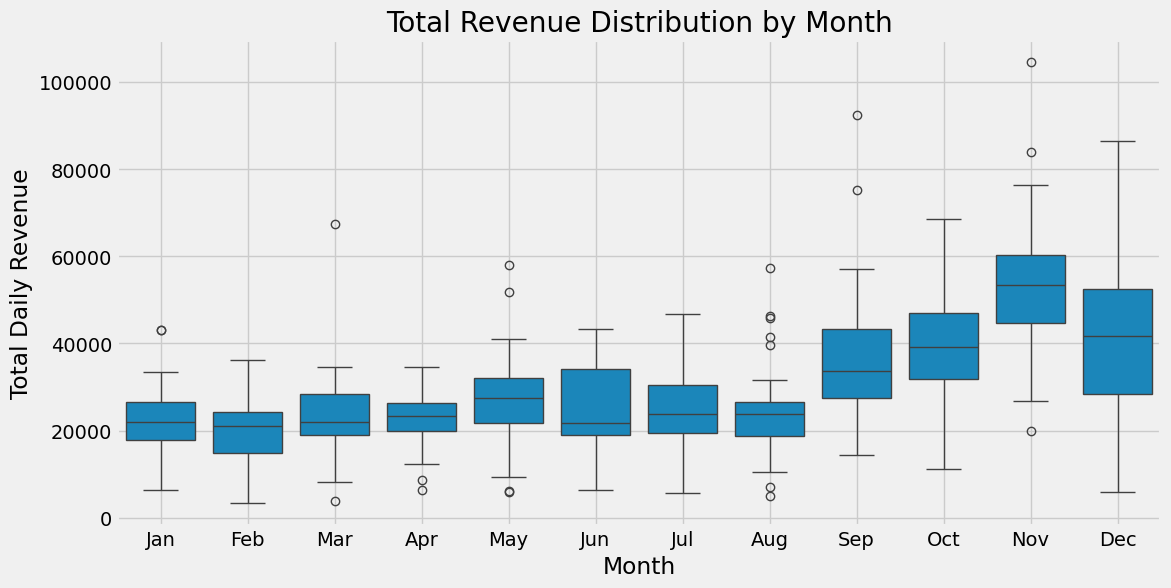

In [12]:
# Ensure 'days' is in datetime format
daily_revenue_df['days'] = pd.to_datetime(daily_revenue_df['days'])

# Add a 'month' column (name or number+name)
daily_revenue_df['month'] = daily_revenue_df['days'].dt.strftime('%b')  # 'Jan', 'Feb', etc.
daily_revenue_df['month_num'] = daily_revenue_df['days'].dt.month       # numeric to help order

# Group by day first to get total daily revenue
daily_totals = daily_revenue_df.groupby(['days', 'month', 'month_num'])['revenue'].sum().reset_index()

# Sort by month number to ensure correct order
daily_totals = daily_totals.sort_values(by='month_num')

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=daily_totals, x='month', y='revenue', ax=ax)
ax.set_title('Total Revenue Distribution by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Total Daily Revenue')
plt.grid(True)
plt.show()